In [28]:
import gym
from gym import spaces
import numpy as np
import pandas as pd
import random
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

In [34]:
df = pd.read_parquet('../eda/prepared_merge/prepared_merge_16.parquet', engine='pyarrow').fillna(0)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371639 entries, 0 to 1371638
Data columns (total 47 columns):
 #   Column                        Non-Null Count    Dtype              
---  ------                        --------------    -----              
 0   session_id                    1371639 non-null  Int32              
 1   timestamp_click               1371639 non-null  datetime64[ns, UTC]
 2   item_id                       1371639 non-null  Int32              
 3   category                      1371639 non-null  object             
 4   click_hour                    1371639 non-null  int64              
 5   click_minute                  1371639 non-null  int64              
 6   click_day                     1371639 non-null  int64              
 7   click_dayofweek               1371639 non-null  int64              
 8   click_is_weekend              1371639 non-null  int64              
 9   click_month                   1371639 non-null  int64              
 10  catego

In [ ]:
# Обновляем список признаков, которые не будут входить в наблюдение.
features_to_drop = ['session_id', 'timestamp_click', 'timestamp_buy', 
                    'conversion', 'category', 'category_type', 
                    'price', 'quantity', 
                    'buy_hour', 'buy_minute', 'buy_day', 'buy_dayofweek', 'buy_is_weekend', 'buy_month',
                    'total_amount', 'session_buy_count', 'total_amount_sum', 
                    'time_diff', 'conversion_session', 'avg_time_diff', 'conversion_rate']

class RecommenderEnv(gym.Env):
    """
    Окружение для RL-агента, задача которого – рекомендовать товар,
    чтобы максимизировать вероятность покупки (conversion == 1).
    """
    def __init__(self, df):
        super(RecommenderEnv, self).__init__()
        self.df = df.copy()
        
        # Получаем уникальные сессии и сортируем их
        self.sessions = np.sort(self.df['session_id'].unique())
        self.current_session_idx = 0
        self._set_current_session()
        
        # Создаем маппинг: список уникальных item_id (если в df есть закодированные или нет)
        self.unique_item_ids = np.sort(self.df['item_id'].unique())
        # Определяем пространство действий как количество уникальных товаров
        self.action_space = spaces.Discrete(len(self.unique_item_ids))
        
        # Определяем пространство наблюдения.
        # Используем все признаки, кроме перечисленных в features_to_drop
        features = [col for col in self.df.columns if col not in features_to_drop]
        
        # Определяем размерность наблюдения, используя первую строку текущей сессии
        sample_obs = self.current_session.iloc[0][features].values.astype(np.float32)
        self.observation_features = features
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(sample_obs.shape[0],), dtype=np.float32)
    
    def _set_current_session(self):
        self.current_session = self.df[self.df['session_id'] == self.sessions[self.current_session_idx]].reset_index(drop=True)
        self.current_step = 0
        
    def reset(self):
        self.current_session_idx = (self.current_session_idx + 1) % len(self.sessions)
        self._set_current_session()
        return self._get_observation()
    
    def _get_observation(self):
        # Возвращаем наблюдение для текущего шага в виде массива чисел.
        if self.current_step < len(self.current_session):
            obs = self.current_session.iloc[self.current_step][self.observation_features]
            try:
                return obs.values.astype(np.float32)
            except ValueError as e:
                print("Ошибка преобразования наблюдения:", e)
                return np.zeros(self.observation_space.shape, dtype=np.float32)
        else:
            return np.zeros(self.observation_space.shape, dtype=np.float32)
    
    def step(self, action):
        # Получаем текущую строку
        current_row = self.current_session.iloc[self.current_step]
        # Изменяем выбранное действие в реальное item_id через маппинг
        chosen_item_id = self.unique_item_ids[action]
        
        # Если выбранный товар совпадает с item_id текущей строки и conversion равен 1, награда = 1, иначе 0.
        reward = 1 if (chosen_item_id == current_row['item_id'] and current_row['conversion'] == 1) else 0
        
        self.current_step += 1
        done = self.current_step >= len(self.current_session)
        obs = self._get_observation() if not done else np.zeros(self.observation_space.shape, dtype=np.float32)
        return obs, reward, done, {}
    
    def render(self, mode='human'):
        pass

# Функция для дискретизации состояния (приведение numpy массива к хэшируемому кортежу)
def discretize_state(state, decimals=1):
    return tuple(np.round(state, decimals=decimals))

class QLearningAgent:
    def __init__(self, action_space, learning_rate=0.1, discount_factor=0.99, 
                 exploration_rate=1.0, exploration_decay=0.995):
        self.action_space = action_space
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        self.epsilon_decay = exploration_decay
        self.q_table = defaultdict(lambda: np.zeros(self.action_space.n))
    
    def choose_action(self, state):
        state_key = discretize_state(state)
        if random.random() < self.epsilon:
            return self.action_space.sample()
        else:
            return int(np.argmax(self.q_table[state_key]))
    
    def update(self, state, action, reward, next_state):
        state_key = discretize_state(state)
        next_state_key = discretize_state(next_state)
        best_next_action = int(np.argmax(self.q_table[next_state_key]))
        td_target = reward + self.gamma * self.q_table[next_state_key][best_next_action]
        td_error = td_target - self.q_table[state_key][action]
        self.q_table[state_key][action] += self.lr * td_error
        self.epsilon *= self.epsilon_decay

In [ ]:
# Создаем окружение и агента
env = RecommenderEnv(df)
agent = QLearningAgent(env.action_space)

Episode 50/1000, Total Reward: 0, Epsilon: 0.0000
Episode 100/1000, Total Reward: 0, Epsilon: 0.0000
Episode 150/1000, Total Reward: 0, Epsilon: 0.0000
Episode 200/1000, Total Reward: 0, Epsilon: 0.0000
Episode 250/1000, Total Reward: 0, Epsilon: 0.0000
Episode 300/1000, Total Reward: 0, Epsilon: 0.0000
Episode 350/1000, Total Reward: 0, Epsilon: 0.0000
Episode 400/1000, Total Reward: 0, Epsilon: 0.0000
Episode 450/1000, Total Reward: 0, Epsilon: 0.0000
Episode 500/1000, Total Reward: 0, Epsilon: 0.0000
Episode 550/1000, Total Reward: 0, Epsilon: 0.0000
Episode 600/1000, Total Reward: 0, Epsilon: 0.0000
Episode 650/1000, Total Reward: 0, Epsilon: 0.0000
Episode 700/1000, Total Reward: 0, Epsilon: 0.0000
Episode 750/1000, Total Reward: 0, Epsilon: 0.0000
Episode 800/1000, Total Reward: 0, Epsilon: 0.0000
Episode 850/1000, Total Reward: 0, Epsilon: 0.0000
Episode 900/1000, Total Reward: 0, Epsilon: 0.0000
Episode 950/1000, Total Reward: 0, Epsilon: 0.0000
Episode 1000/1000, Total Reward:

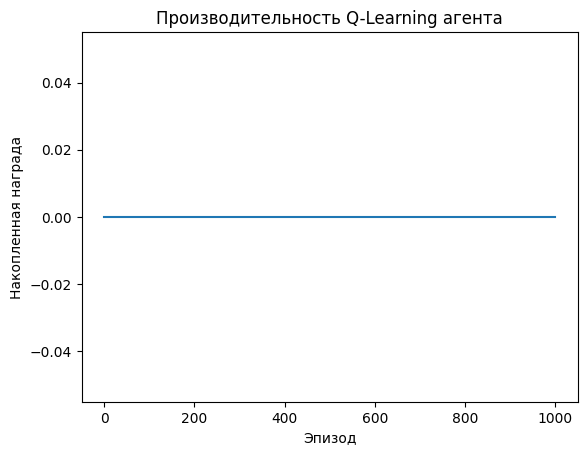

In [36]:
num_episodes = 1000
episode_rewards = []

for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.update(state, action, reward, next_state)
        state = next_state
        total_reward += reward
    episode_rewards.append(total_reward)
    if (episode + 1) % 50 == 0:
        print(f'Episode {episode+1}/{num_episodes}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.4f}')

# Построим график производительности
import matplotlib.pyplot as plt
plt.plot(episode_rewards)
plt.xlabel("Эпизод")
plt.ylabel("Накопленная награда")
plt.title("Производительность Q-Learning агента")
plt.show()
